### Text Sentiment Analysis

#### This is version six

This three-part model is a complete pipeline for sentiment analysis using a pre-trained BERT model. The pipeline consists of preprocessing, fine-tuning the BERT transformer network, and evaluation.

Preprocessing: This stage involves loading and preparing the dataset for use with the BERT model. The raw text data is tokenized and converted to input format compatible with the BERT model. The dataset is then split into training and validation sets, and data loaders are created to handle data batching and shuffling. The preprocessing stage also includes mapping sentiment labels to integer values, as required by the model.

BERT Transformer Network: This stage focuses on fine-tuning a pre-trained BERT model for the specific task of sentiment analysis. Instead of training a Transformer model from scratch, the pre-trained BERT model is adapted to the new task using a few additional training epochs. By leveraging the knowledge already gained by the BERT model during pre-training, the fine-tuning process usually results in better performance and faster convergence. The BERT model is set up with the appropriate number of output labels for the sentiment classification task, and the training process includes an optimizer and a learning rate scheduler to adjust learning rates during training.

Evaluation and Plotting: After fine-tuning the BERT model, its performance is evaluated on the validation set. Predictions are saved in a CSV file, and a classification report is generated to provide insights into the model's performance in terms of precision, recall, and F1-score for each sentiment class. This stage helps assess the effectiveness of the model and identify any areas that may require improvement.

Note: Only one training epoch in th BERT model was undertaken intentionally. This model is the benchmark for the scratch built transformers model (v7). Until that model can beat one training epoch, further ones aren't necessary. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copy the data to your local drive
!cp /content/drive/MyDrive/archive/archive-3/Tweets.csv /content/

In [3]:
# Install the transformers library as needed. 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r':\)', ' smile ', text)
    text = re.sub(r':\(', ' sad ', text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    text = ' '.join(tokens)
    
    return text

data = pd.read_csv("Tweets.csv")
data['cleaned_text'] = data['text'].apply(clean_text)
data.to_csv('preprocessed_tweets.csv', index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


def create_data_loader(df, tokenizer, max_len, batch_size):
    sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}
    df["airline_sentiment"] = df["airline_sentiment"].map(sentiment_map)

    sequences = tokenizer(
        df["text"].tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    )
    input_ids = sequences["input_ids"]
    attention_mask = sequences["attention_mask"].bool()
    labels = torch.tensor(df["airline_sentiment"].values, dtype=torch.long)

    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()

    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        targets = batch[2].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


def evaluate(model, data_loader, loss_fn, device):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            targets = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


def save_predictions(model, data_loader, device, file_path):
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            targets = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    predictions_df = pd.DataFrame({"true_label": all_targets, "prediction": all_predictions})
    predictions_df.to_csv(file_path, index=False)

    return predictions_df


# Load the data
df = pd.read_csv("preprocessed_tweets.csv")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128
BATCH_SIZE = 64

# Create the data loaders
data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(data_loader.dataset))
val_size = len(data_loader.dataset) - train_size
train_data, val_data = random_split(data_loader.dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Set up the model and training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,  # Number of output labels
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

EPOCHS = 1
total_steps = len(train_loader) * EPOCHS

# Use a linear scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)

    # Update the scheduler
    scheduler.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Evaluate the model and save predictions
predictions_df = save_predictions(model, val_loader, device, "predictions.csv")

# Print classification report
print(classification_report(predictions_df["true_label"], predictions_df["prediction"]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/1
Train Loss: 0.5523 | Train Acc: 0.7737
Val Loss: 0.4508 | Val Acc: 0.8272
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1821
           1       0.71      0.60      0.65       620
           2       0.78      0.78      0.78       487

    accuracy                           0.83      2928
   macro avg       0.79      0.77      0.78      2928
weighted avg       0.82      0.83      0.82      2928



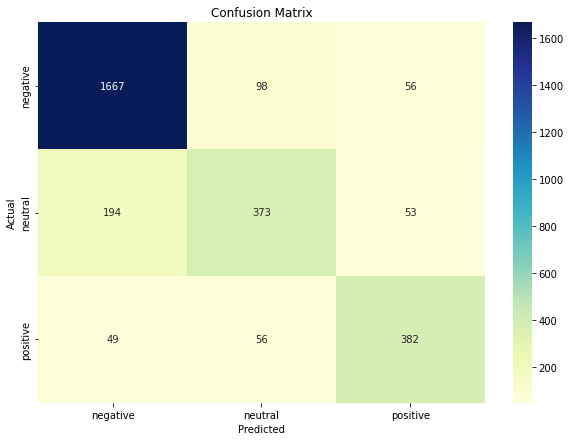

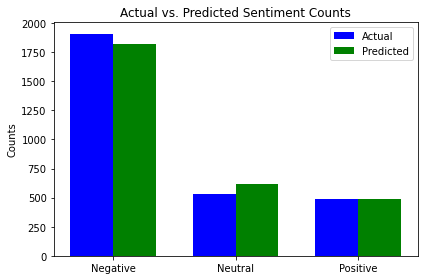

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the predictions data
data = pd.read_csv("predictions.csv")

# Create a confusion matrix
cm = confusion_matrix(data["true_label"], data["prediction"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Bar plot for actual vs. predicted counts
labels = ['Negative', 'Neutral', 'Positive']
actual_counts = np.bincount(data['prediction'])
predicted_counts = np.bincount(data['true_label'])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, actual_counts, width, label='Actual', color='b')
rects2 = ax.bar(x + width / 2, predicted_counts, width, label='Predicted', color='g')

ax.set_ylabel('Counts')
ax.set_title('Actual vs. Predicted Sentiment Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()
